In [71]:
import sys
sys.path.append('/root/darknet')
import darknet as dn
import cv2 as cv
import os
from matplotlib import pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [72]:
batch_size = 64
img_height = 125
img_width = 125
validation_split = 0.2
cnn_class_names = ['off', 'on']

In [73]:
network, class_names, class_colors = dn.load_network("/root/ML-final-assignment/yolov4/monitor.cfg",
                              "/root/ML-final-assignment/yolov4/monitor.data",
                              "/root/ML-final-assignment/yolov4/monitor.weights")
network_width = dn.network_width(network)
network_height = dn.network_height(network)

model = tf.keras.models.load_model("/root/ML-final-assignment/CNN/monitor.h5")

   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   9 route  8 2 	                           ->  208 x 208 x 128 
  10 conv     64       1 x 1/ 1    208 x 208 x 128 ->  208 x 208 x  64 0.709 BF
  11 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
  12 con


 seen 64, trained: 256 K-images (4 Kilo-batches_64) 
Loaded - names_list: /root/ML-final-assignment/yolov4/monitor.names, classes = 1 
 Try to load cfg: /root/ML-final-assignment/yolov4/monitor.cfg, weights: /root/ML-final-assignment/yolov4/monitor.weights, clear = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 
 Try to load weights: /root/ML-final-assignment/yolov4/monitor.weights 


In [74]:
def image_detector(img, n_width, n_height):
    '''
    使用yolo辨識圖片
    '''
    #建立一張Darknet的空白圖片
    darknet_image = dn.make_image(n_width, n_height, 3)
    #將原始圖片轉為RGB格式
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    #依據網路的規格調整圖片尺寸 resize(被修改影像, (w, h), interpolation=cv.INTER_LINEAR(插值方式))
    img_resized = cv.resize(img_rgb, (n_width, n_height), interpolation=cv.INTER_LINEAR) 
    # 取得圖片的長寬，讓畫框時比例正常
    img_height, img_width, _ = img.shape
    height_ratio = img_height / n_height
    width_ratio = img_width / n_width
    #將調整過大小的影像插入Darknet空白圖片
    dn.copy_image_from_bytes(darknet_image, img_resized.tobytes())
    #辨識圖片
    detections = dn.detect_image(network, class_names, darknet_image)
    #清除圖片
    dn.free_image(darknet_image)
    return detections, width_ratio, height_ratio

def crop_picture(image, bbox):
    '''
    裁切圖片
    '''
    left, top, right, bottom = dn.bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(
        top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    image = image[top:bottom, left:right]
    return image

def show_img_jupyter(img):
    image_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.show()

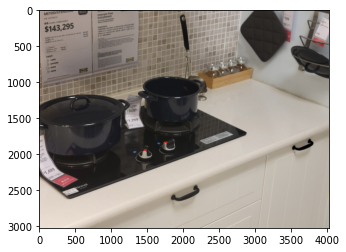

有未關閉的瓦斯爐開關


In [75]:
# 有開啟開關的圖片
image = cv.imread("/root/ML-final-assignment/yolov4/stove_switch/GAS_032.jpg")

# 沒有開啟開關的圖片
#image = cv.imread("/root/ML-final-assignment/yolov4/stove_switch/GAS_003.jpg")

show_img_jupyter(image)

print("計算中...", end="\r")

have_on_switch = False
detections, width_ratio, height_ratio = image_detector(image, network_width, network_height)
for label, confidence, bbox in detections:
    img = image.copy()
    img = crop_picture(img, bbox)
    cv.imwrite("/root/ML-final-assignment/temp.png",img)
    img = tf.keras.utils.load_img(
        "/root/ML-final-assignment/temp.png", target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array, verbose=0)
    score = tf.nn.softmax(predictions[0])
    os.remove(r"/root/ML-final-assignment/temp.png")
    if cnn_class_names[np.argmax(score)] == "on":
        have_on_switch = True
        break
if have_on_switch == True:
    print("有未關閉的瓦斯爐開關")
else:
    print("所有的瓦斯爐開關已關閉")